In [1]:
# Datenzugriff
from configs.config import get_path

# Utils
import src.utils.presenter as show
from src.utils.production_process import convert
from src.utils.production_process import initialize as init
from src.utils.analize import check_constrains as check

from src.utils.production_process import time_determination as term
from src.utils.production_process import gen_deadline as gen_deadline
from src.utils.production_process import filter as process_filter

# Solver Model
from src.models.cp import lateness_scheduling as cp_late_schedule
from src.models.cp import lateness_rescheduling as cp_late_reschedule
import src.models.heuristics.fcfs as fcfs


# Simulation
from src.simulation.ProductionDaySimulation import ProductionDaySimulation


# Extern
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 21)

In [2]:
max_time = 60 * 15 # 15 min

## Laden der Produktionsaufträge

In [3]:
data_path = get_path("data", "cp_lateness")
file_template = "02_{text}.csv"

In [4]:
file = file_template.format(text= "all_job_times")

df_job_times_all = pd.read_csv(data_path / file)
df_job_times_all['Job'] = df_job_times_all['Job'].astype(str)
df_job_times_all

,Job,Production_Plan_ID,Arrival,Deadline,Ready Time,Processing Time,Slack
0,0,0,49,2027,1440,395,192
1,1,1,130,2683,1440,510,733
2,2,2,151,2994,1440,568,986
3,3,3,226,3505,1440,655,1410
4,4,4,386,2353,1440,393,520
...,...,...,...,...,...,...,...
415,415,6,28598,30681,28800,416,1465
416,416,4,28606,30573,28800,393,1380
417,417,5,28722,31205,28800,496,1909
418,418,7,28746,31444,28800,539,2105


In [5]:
file = file_template.format(text= "all_jssp")
df_jssp_all = pd.read_csv(data_path / file)
df_jssp_all['Job'] = df_jssp_all['Job'].astype(str)
df_jssp_all

,Job,Production_Plan_ID,Operation,Machine,Processing Time
0,0,0,0,M00,29
1,0,0,1,M01,78
2,0,0,2,M02,9
3,0,0,3,M03,36
4,0,0,4,M04,49
...,...,...,...,...,...
4195,419,8,5,M09,11
4196,419,8,6,M06,40
4197,419,8,7,M07,89
4198,419,8,8,M04,26


## Laden der Initialisierungsdaten vom Tag 1

In [6]:
day_numb = 1

In [7]:
file = file_template.format(text= f"schedule_{day_numb:02d}_init")
df_schedule = pd.read_csv(data_path / file)
df_schedule 

,Job,Production_Plan_ID,Operation,Machine,Arrival,Deadline,Start,Processing Time,End,Lateness,Tardiness,Earliness
0,0,0,0,M00,49,2027,1440,29,1469,-558,0,558
1,4,4,0,M02,386,2353,1440,14,1454,-899,0,899
2,6,6,0,M01,480,2563,1440,46,1486,-1077,0,1077
3,5,5,0,M02,464,2947,1454,84,1538,-1409,0,1409
4,4,4,1,M00,386,2353,1469,6,1475,-878,0,878
...,...,...,...,...,...,...,...,...,...,...,...,...
195,16,1,9,M08,1254,3807,3777,30,3807,0,0,0
196,13,2,9,M04,1001,3844,3811,33,3844,0,0,0
197,18,5,9,M07,1397,3880,3855,25,3880,0,0,0
198,12,8,9,M08,950,3939,3865,74,3939,0,0,0


In [8]:
# bereits Ausgeführte Operationen
file = file_template.format(text= f"execution_{day_numb:02d}")
df_execution = pd.read_csv(data_path / file)
df_execution

,Job,Production_Plan_ID,Operation,Machine,Arrival,Start,Processing Time,End
0,0,0,0,M00,49,1440.00,37.68,1477.68
1,0,0,1,M01,49,1486.00,93.23,1579.23
2,0,0,2,M02,49,1665.49,7.59,1673.08
3,0,0,3,M03,49,1673.08,34.84,1707.92
4,0,0,4,M04,49,1794.92,65.30,1860.22
...,...,...,...,...,...,...,...,...
161,9,9,4,M08,535,2200.24,55.25,2255.49
162,9,9,5,M09,535,2255.49,80.40,2335.89
163,9,9,6,M05,535,2335.89,63.32,2399.21
164,9,9,7,M03,535,2440.21,46.86,2487.07


In [9]:
# für die Vergangenheit geplante Operationen, die nicht geschaft abgearbeitet wurden 
file = file_template.format(text= f"plan_{day_numb:02d}_undone")
df_undone = pd.read_csv(data_path / file)
df_undone

,Job,Production_Plan_ID,Operation,Machine,Arrival,Deadline,Start,Processing Time,End,Lateness,Tardiness,Earliness
0,3,3,8,M09,226,3505,2725,22,2747,-758,0,758
1,18,5,7,M06,1397,3880,2798,65,2863,-1017,0,1017
2,11,9,8,M04,928,3631,2802,90,2892,-739,0,739
3,12,8,7,M07,950,3939,2802,89,2891,-1048,0,1048
4,13,2,5,M05,1001,3844,2862,10,2872,-972,0,972
...,...,...,...,...,...,...,...,...,...,...,...,...
29,16,1,9,M08,1254,3807,3777,30,3807,0,0,0
30,13,2,9,M04,1001,3844,3811,33,3844,0,0,0
31,18,5,9,M07,1397,3880,3855,25,3880,0,0,0
32,12,8,9,M08,950,3939,3865,74,3939,0,0,0


## Rolling Planning ab Tag 2

In [10]:
file_template = "03_simple_{text}.csv"

In [11]:
first_start = 2
last_planning_start = 4

day_length = 1440

Day 02: [2880, 4320)
[INFO] Anzahl Jobs mit Ready Time 2880: 21
[INFO] 34 zusätzliche Operationen hinzugefügt (gesamt: 244).
[INFO] 4 laufende Operation(en) aus vorherigen Tagen enden erst nach Tagesbeginn.

Solver-Status         : OPTIMAL
Objective Value       : 27.00
Best Objective Bound  : 27.00
Laufzeit              : 0.14 Sekunden


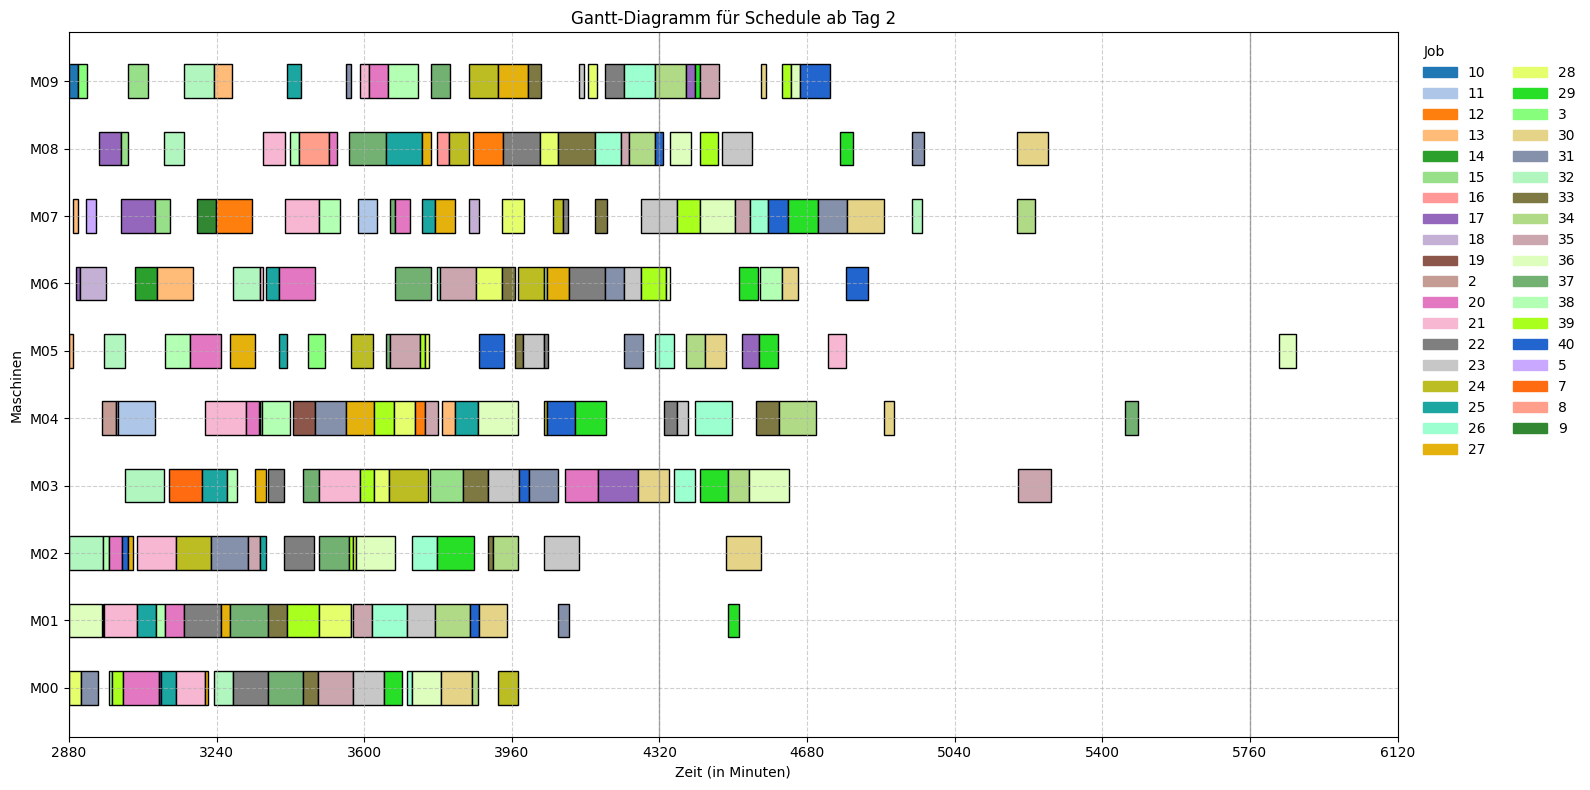

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job

+++ Alle Constraints wurden erfüllt.

label
<-240           0
-240 - -180     0
-180 - -120     0
-120 - -60      0
-60 - 0         1
0              35
0 - 60          1
60 - 120        0
120 - 180       0
180 - 240       0
>240            0
Name: count, dtype: int64
[48:00:00] Job 10 started on M09
[48:00:00] Job 13 started on M05
[48:00:00] Job 28 started on M00
[48:00:00] Job 32 started on M02
[48:00:00] Job 36 started on M01
[48:09:26] Job 13 finished on M05 (after 09 minutes 26 seconds)
[48:10:00] Job 13 started on M07
[48:17:00] Job 17 started on M06
[48:19:49] Job 13 finished on M07 (after 09 minutes 50 seconds)
[48:23:11] Job 28 finished on M00 (after 23 minutes 11 seconds)
[48:27:30] Job 17 finished on M06 (after 10 minutes 30 seconds)
[48:27:30] Job 18 started on M

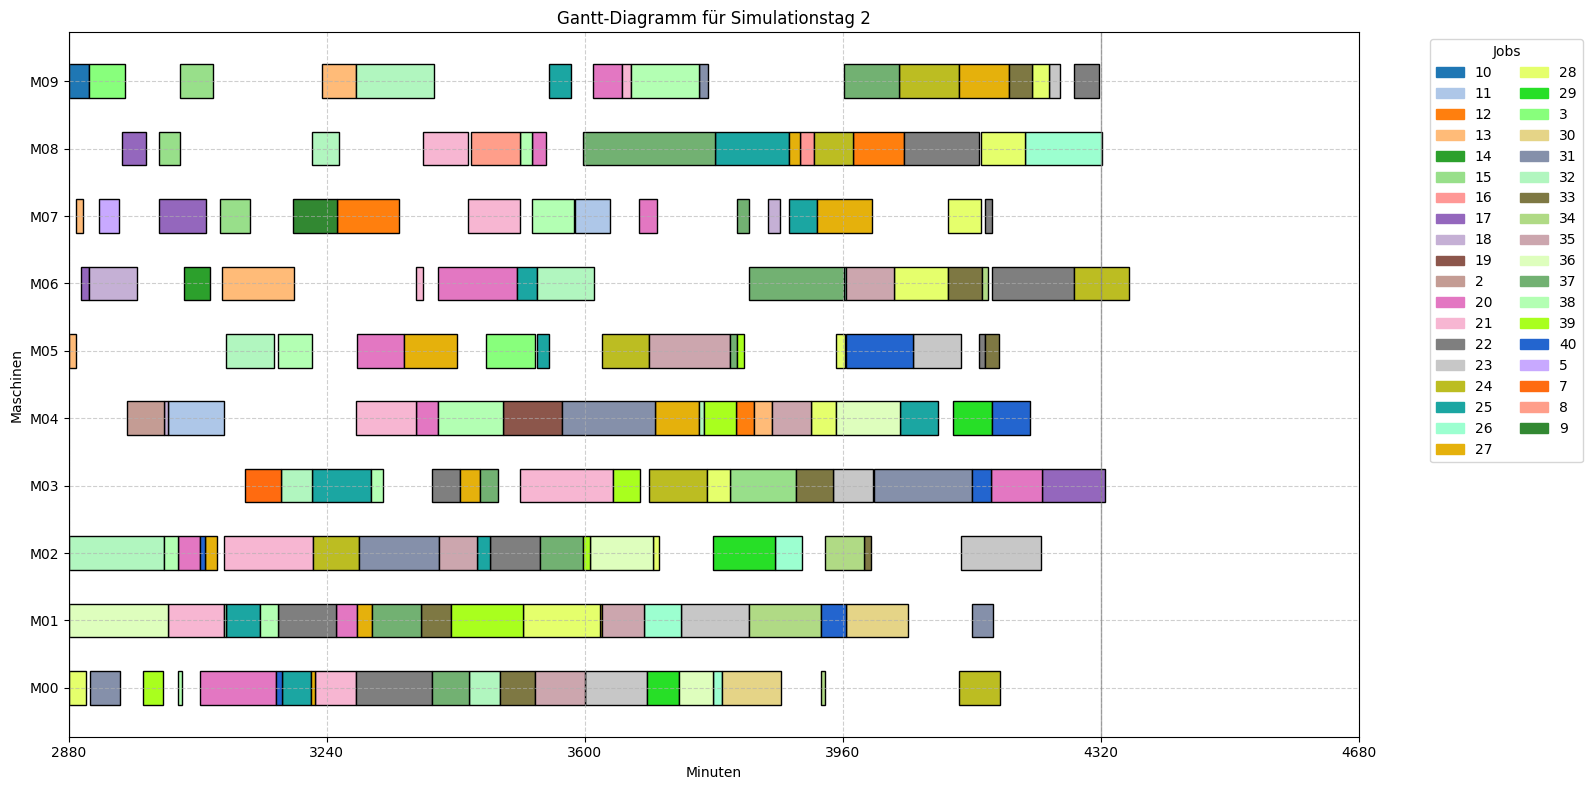

----------------------------------------------------------------------
Day 03: [4320, 5760)
[INFO] Anzahl Jobs mit Ready Time 4320: 17
[INFO] 65 zusätzliche Operationen hinzugefügt (gesamt: 235).
[INFO] 3 laufende Operation(en) aus vorherigen Tagen enden erst nach Tagesbeginn.

Solver-Status         : OPTIMAL
Objective Value       : 4204.00
Best Objective Bound  : 4200.00
Laufzeit              : 0.59 Sekunden


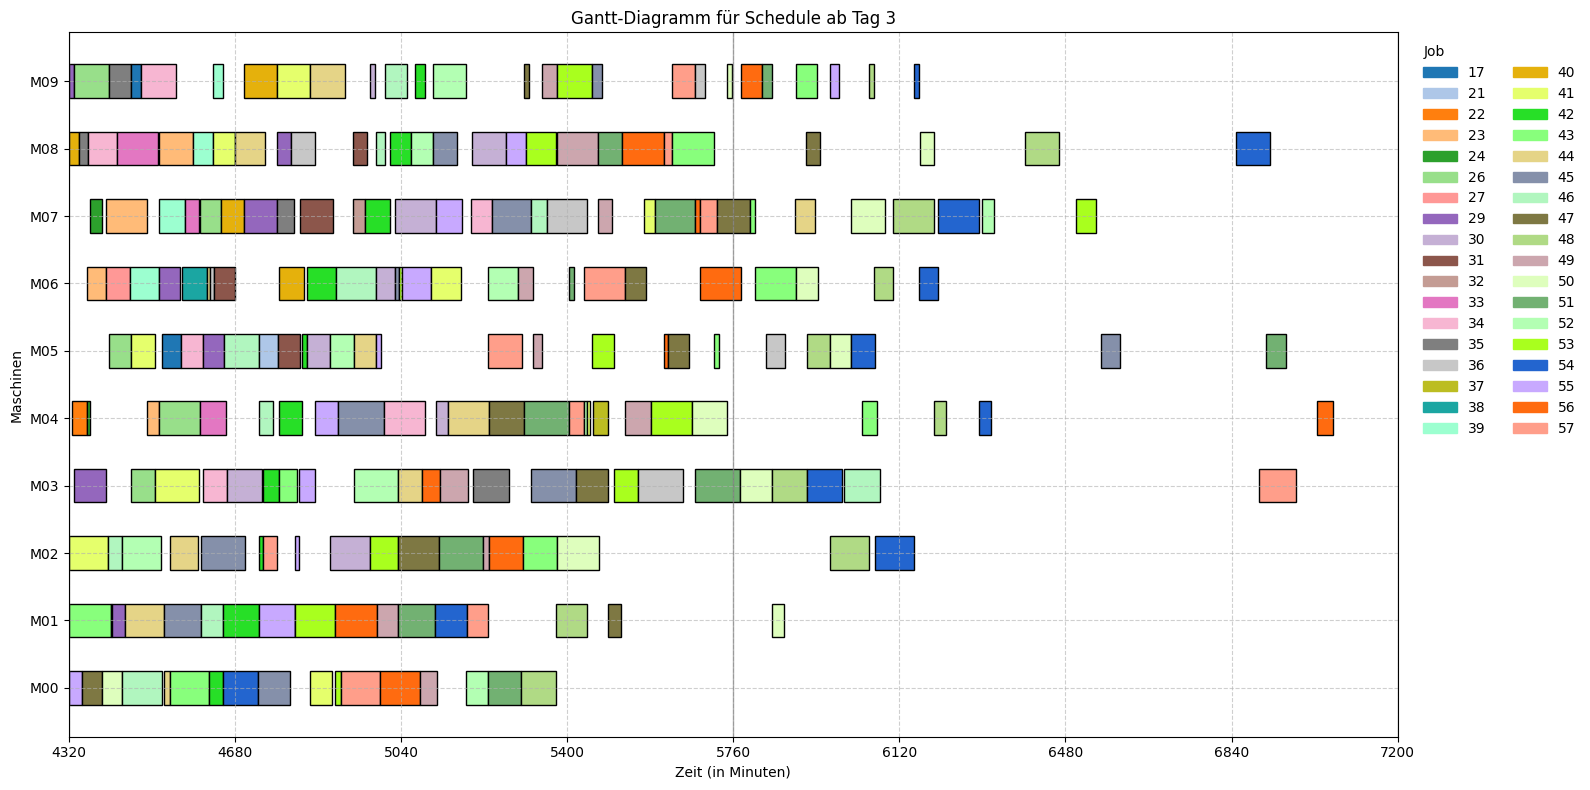

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job

+++ Alle Constraints wurden erfüllt.

label
<-240           0
-240 - -180     0
-180 - -120     0
-120 - -60      0
-60 - 0         1
0              28
0 - 60          4
60 - 120        1
120 - 180       0
180 - 240       0
>240            2
Name: count, dtype: int64
[72:00:00] Job 29 started on M09
[72:00:00] Job 41 started on M02
[72:00:00] Job 43 started on M01
[72:00:00] Job 55 started on M00
[72:01:00] Job 40 started on M08
[72:07:00] Job 22 started on M04
[72:15:54] Job 29 finished on M09 (after 15 minutes 55 seconds)
[72:15:54] Job 26 started on M09
[72:15:54] Job 29 started on M03
[72:17:30] Job 40 finished on M08 (after 16 minutes 30 seconds)
[72:22:00] Job 35 started on M08
[72:29:22] Job 55 finished on M00 (after 29 minutes 22 seconds)
[72:29:22] Job 47 started on

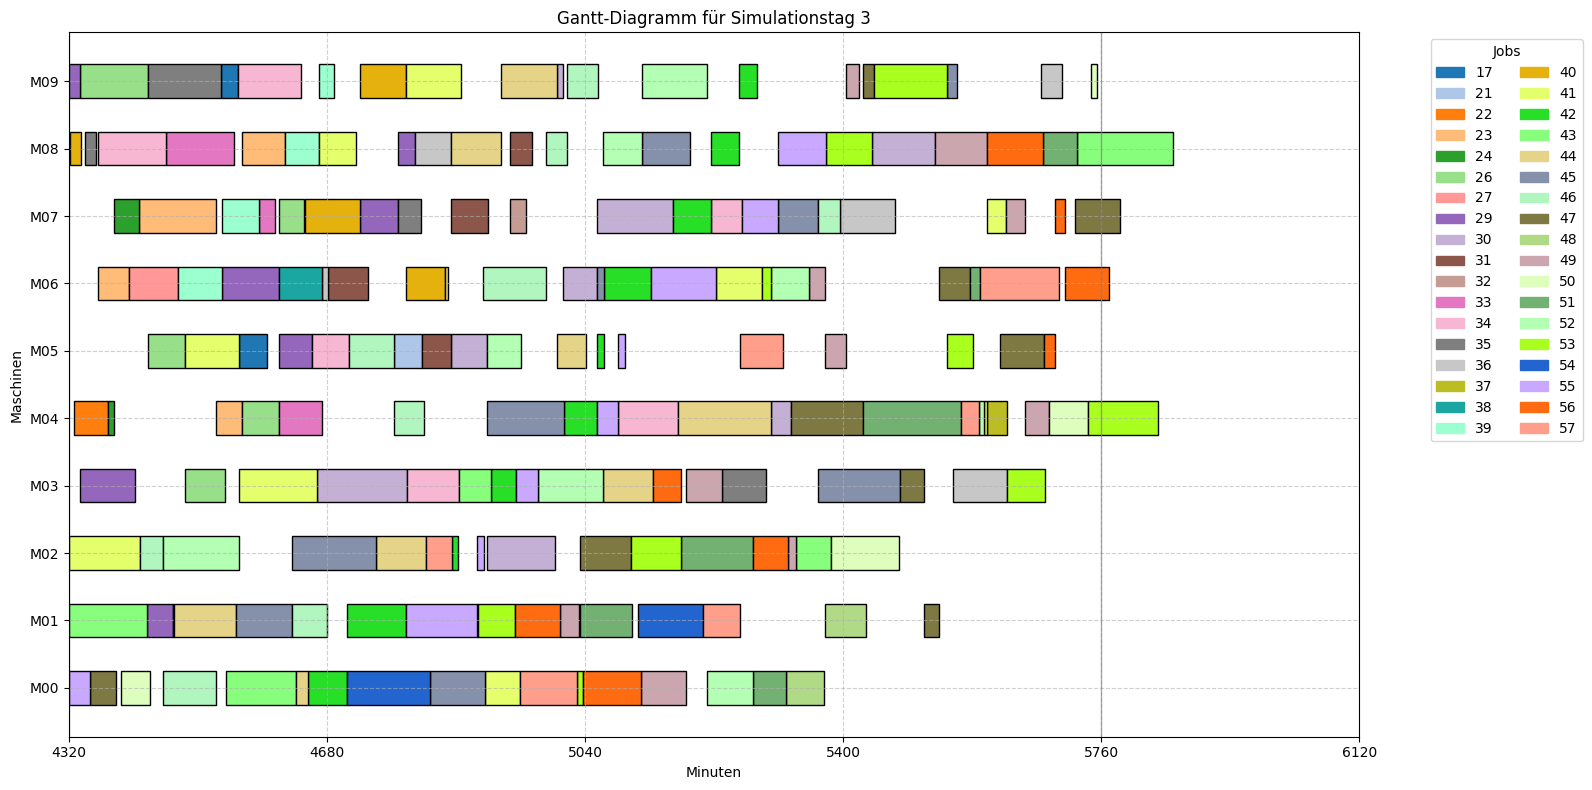

----------------------------------------------------------------------
Day 04: [5760, 7200)
[INFO] Anzahl Jobs mit Ready Time 5760: 17
[INFO] 45 zusätzliche Operationen hinzugefügt (gesamt: 215).
[INFO] 4 laufende Operation(en) aus vorherigen Tagen enden erst nach Tagesbeginn.

Solver-Status         : OPTIMAL
Objective Value       : 2.00
Best Objective Bound  : 2.00
Laufzeit              : 0.35 Sekunden


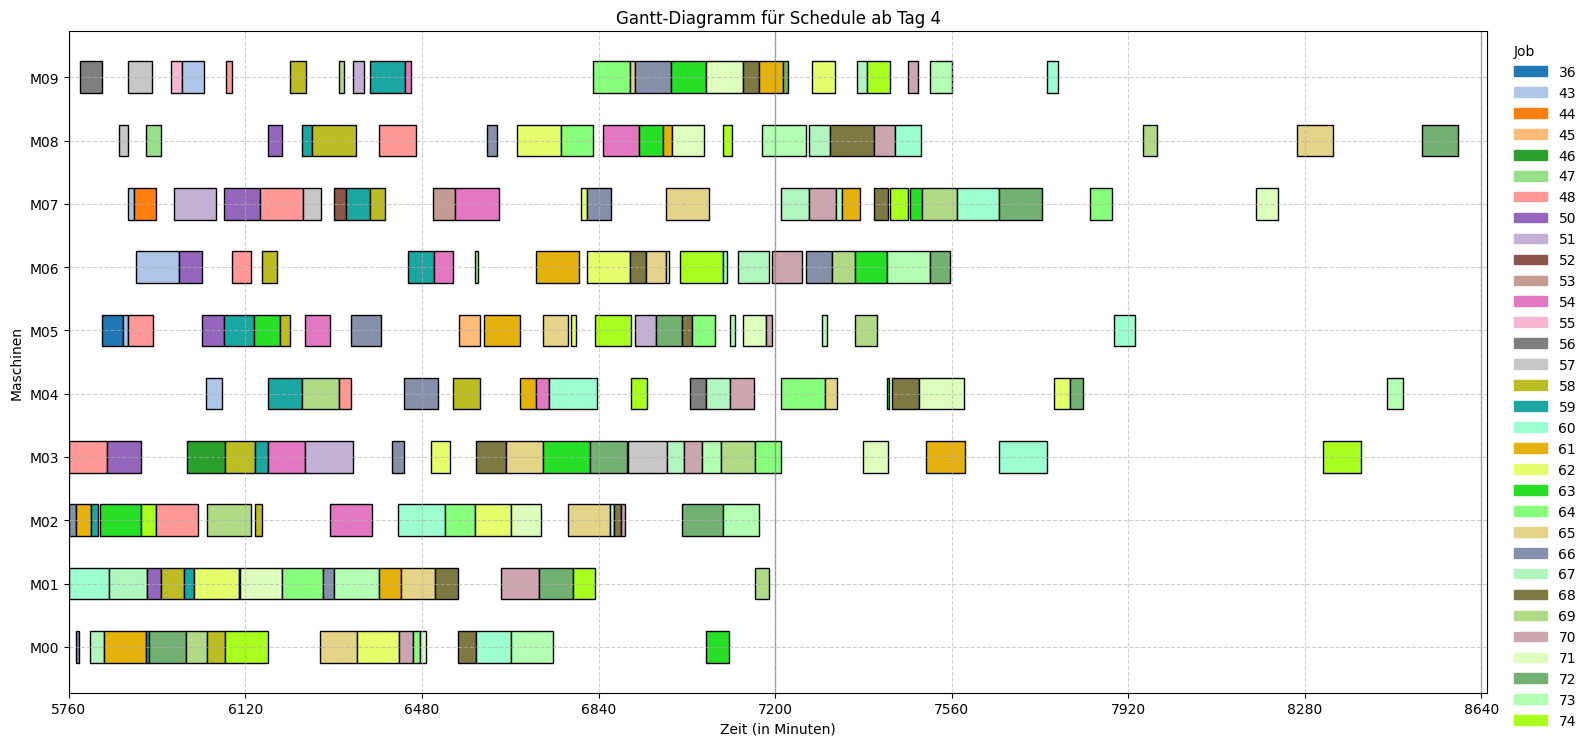

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job

+++ Alle Constraints wurden erfüllt.

label
<-240           0
-240 - -180     0
-180 - -120     0
-120 - -60      0
-60 - 0         1
0              31
0 - 60          0
60 - 120        0
120 - 180       0
180 - 240       0
>240            0
Name: count, dtype: int64
[96:00:00] Job 66 started on M02
[96:01:00] Job 48 started on M03
[96:01:00] Job 60 started on M01
[96:16:13] Job 66 finished on M02 (after 16 minutes 13 seconds)
[96:16:13] Job 61 started on M02
[96:16:13] Job 66 started on M00
[96:21:01] Job 66 finished on M00 (after 04 minutes 49 seconds)
[96:22:00] Job 56 started on M09
[96:42:00] Job 67 started on M00
[96:51:46] Job 56 finished on M09 (after 29 minutes 47 seconds)
[96:53:00] Job 61 finished on M02 (after 36 minutes 47 seconds)
[96:53:00] Job 59 started on M

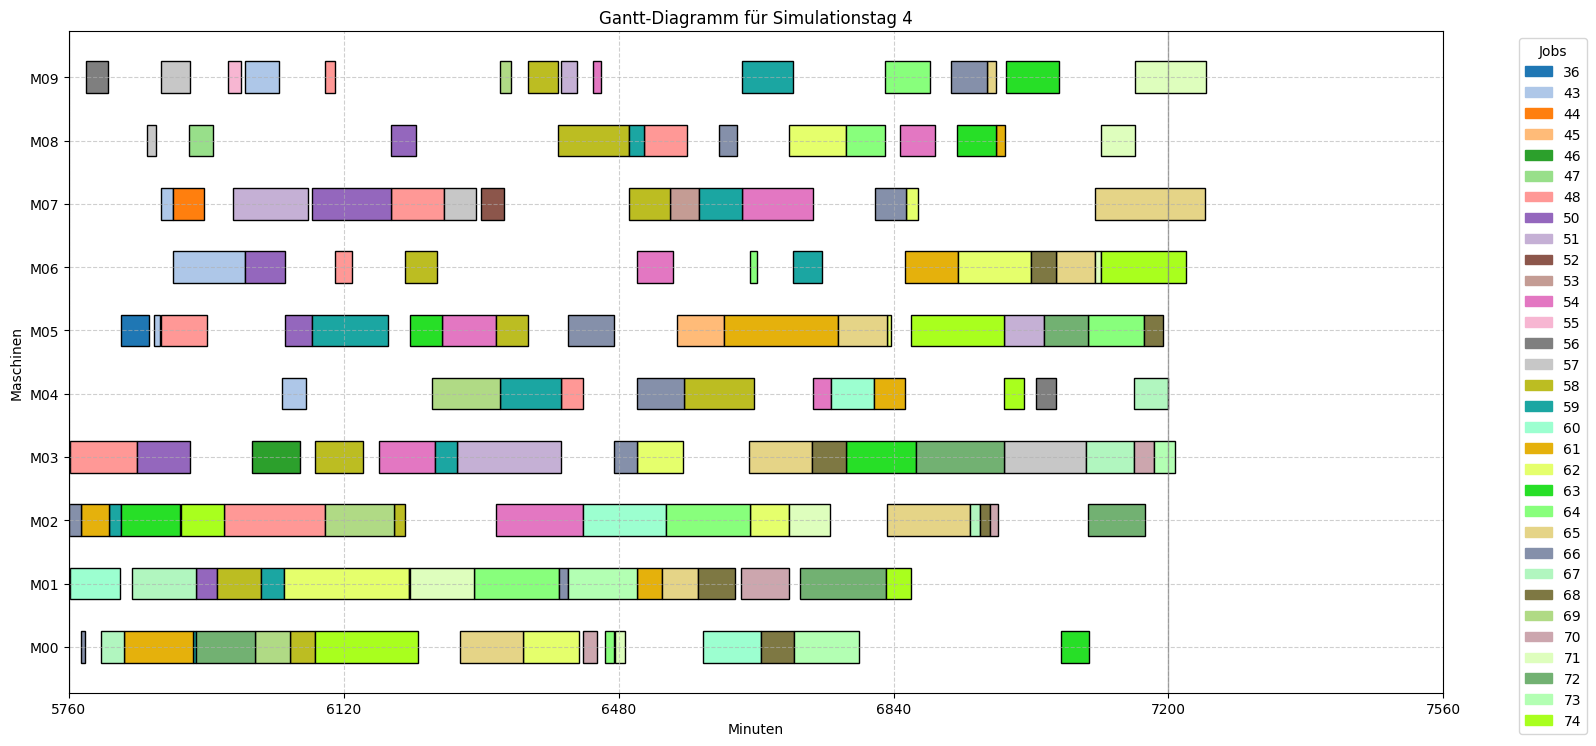

----------------------------------------------------------------------


In [12]:
for day_numb in range(first_start, last_planning_start + 1):
    day_start = day_length*day_numb 
    day_end = day_start + day_length
    print(f"Day {day_numb:02d}: [{day_start}, {day_end})")

    # ------------------------ I. Operationsvorbereitung ------------------------
    #----------------------------------------------------------------------------
    
    # ---------- a) Filterung nach der aktuellen "Ready Time" ----------
    df_jssp_curr, df_job_times_curr = process_filter.jobs_by_ready_time(df_job_times_all, df_jssp_all, ready_time = day_start, verbose=True)

    
    # ---------- b) Zusammenführung mit unerledigten Operationen -------
    df_jssp_curr = process_filter.extend_with_undone_operations(df_jssp_curr, df_undone, verbose=True)
    df_times_curr = process_filter.update_times_after_operation_changes(df_job_times_all, df_jssp_curr)

    # ------------------- II. Relevante laufende Operationen -------------------------
    df_execution_important = process_filter.get_operations_running_into_day(df_execution, day_start, verbose=True)

    # ------------------------ III. Rescheduling --------------------------------
    #----------------------------------------------------------------------------

    df_schedule = cp_late_reschedule.solve_jssp_by_tardiness_and_earliness_with_fixed_ops(df_jssp_curr, df_times_curr, 
                                                                                          df_execution_important, w_t = 5,
                                                                                          reschedule_start = day_start, 
                                                                                          msg=False, timeLimit=max_time, gapRel= 0.002)
    
    file = file_template.format(text= f"schedule_{day_numb:02d}")
    df_schedule.to_csv(data_path / file, index=False)
    
    show.plot_gantt(df_schedule, perspective="Machine", title=f"Gantt-Diagramm für Schedule ab Tag {day_numb}")
    check.all_in_one(df_schedule)

    last_ops = df_schedule.sort_values(['Job', 'Operation']).drop_duplicates('Job', keep='last')
    print(show.count_column_grouped(last_ops, "Lateness", max_val = 240, steps= 60))

    # ------------------------ IV. Simulation -----------------------------------
    simulation = ProductionDaySimulation(df_schedule, vc=0.25)
    df_execution = simulation.run(start_time=day_start, end_time=day_end)
    if not df_execution.empty:
        show.plot_gantt_machines(df_execution, title=f"Gantt-Diagramm für Simulationstag {day_numb}")
    else:
        print(f"Nothing executed on day {day_numb}")

    df_undone = process_filter.get_unexecuted_operations(df_schedule, df_execution)
    print("-"*70)